In [1]:
#Import Libraries
from category_encoders import OrdinalEncoder
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
#Read and view data
data_path = ('../data/')
df = pd.read_csv(data_path+'character_predictions/character_predictions.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No               1946 non-null   int64  
 1   actual             1946 non-null   int64  
 2   pred               1946 non-null   int64  
 3   alive              1946 non-null   float64
 4   plod               1946 non-null   float64
 5   name               1946 non-null   object 
 6   title              938 non-null    object 
 7   male               1946 non-null   int64  
 8   culture            677 non-null    object 
 9   dateOfBirth        433 non-null    float64
 10  DateoFdeath        444 non-null    float64
 11  mother             21 non-null     object 
 12  father             26 non-null     object 
 13  heir               23 non-null     object 
 14  house              1519 non-null   object 
 15  spouse             276 non-null    object 
 16  book1              1946 

In [3]:
df.head()

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


This was hard to decide which columns to drop as personally I know that in the series things such as houses and hiers, sposes, parents, and popularity all contributed to whether a person survived or not.

In [4]:
#Write wrangle function
def wrangle(filepath):
    #Read data
    df = pd.read_csv(filepath,
                     #Set index column
                    index_col='S.No')
    
    #select columns to drop that are not important or lead to leakage
    drop_cols = df[['actual','pred', 'book1', 'book2', 
                    'book3', 'book4', 'book5', 'isPopular', 
                    'DateoFdeath', 'numDeadRelations', 
                    'boolDeadRelations']]
    
    #drop columns from data frame
    df.drop(columns=drop_cols, inplace=True)
    
    #fill age na values
    df['age'].fillna(0, inplace=True)
    
    #Change age from float to int
    df['age'].astype(int)
    
    #drop high cardinality features
    hc_cutoff = 300
    hc_drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > hc_cutoff]
    df.drop(columns=hc_drop_cols, inplace=True)
    
    #return datafram
    return df

#apply wrangle function
df = wrangle(data_path+'character_predictions/character_predictions.csv')

In [19]:
df.head()

,alive,plod,title,male,culture,dateOfBirth,mother,father,heir,spouse,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,,,
1,0.054,0.946,NaN,1,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,1.0,0.0,0.0,NaN,0,0,0.0,0.605351,0
2,0.387,0.613,Lord of the Crossing,1,Rivermen,208.0,NaN,NaN,NaN,Perra Royce,NaN,NaN,NaN,1.0,1,1,97.0,0.896321,1
3,0.493,0.507,Ser,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0.0,0.267559,1
4,0.076,0.924,Queen,0,NaN,82.0,NaN,NaN,NaN,Viserys I Targaryen,NaN,NaN,NaN,0.0,1,1,23.0,0.183946,0
5,0.617,0.383,Greenstone,0,Dornish,276.0,NaN,NaN,NaN,Eldon Estermont,NaN,NaN,NaN,1.0,1,1,29.0,0.043478,1


In [6]:
#Set target
target = 'isAlive'

#Creat target vector
y = df[target]

#Create feature matrix
X = df.drop(columns=target)

#Check shape
print('The shape of y is:', y.shape)
print('The shape of X is:', X.shape)

The shape of y is: (1946,)
The shape of X is: (1946, 18)


In [7]:
#Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=26)

In [8]:
#Establish baseline accuracy
print('Baseline accuracy score:',y_train.value_counts(normalize=True).max())

Baseline accuracy score: 0.7429305912596401


In [9]:
#Build model
model = make_pipeline(
    #Encode categorical data
    OrdinalEncoder(), 
    #fill missing values
    SimpleImputer(strategy='median'), 
    #select model type
    RandomForestClassifier(n_estimators=100, random_state=26, n_jobs=-2)
)

#Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['title', 'culture', 'mother', 'father',
                                      'heir', 'spouse'],
                                mapping=[{'col': 'title',
                                          'data_type': dtype('O'),
                                          'mapping': NaN                      1
Septon                   2
Ser                      3
Dreadfort                4
Iron Islands             5
                      ... 
Tower of Glimmering    227
Broad Arch             228
Three Towers           229
Cobblecat              230
Big BucketThe Wull     231
Length: 231, dtype: int64},
                                         {'col': 'culture',
                                          'data_type': dtype('O'),
                                          'map...
dtype: int64},
                                         {'col': 'spouse',
                                          'data_type': dtype('O'),
         

In [10]:
#Check metrics
#training accuracy
print('Train set accuracy:', model.score(X_train, y_train))

#Validation accuracy
print('Validation set accuracy:', model.score(X_val, y_val))

Train set accuracy: 0.9955012853470437
Validation set accuracy: 0.7769230769230769


In [11]:
#Get permutated importances
permutated = permutation_importance(model, 
                                 X_val, 
                                 y_val,
                                 n_repeats=5, 
                                 n_jobs=-2, 
                                 random_state=26 )
#Train model on top 5 importances
cols_drop = X_val.columns

X_train_top_5 = X_train[pd.Series(permutated['importances_mean'], index=cols_drop).sort_values().tail(5).index]
X_val_top_5 =  X_val[pd.Series(permutated['importances_mean'], index=cols_drop).sort_values().tail(5).index]

#build permutated model
permutated_model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=26, n_jobs=-2)
)

#fit model
permutated_model.fit(X_train_top_5, y_train)
print('Permutated Validation set accuracy', permutated_model.score(X_val_top_5, y_val))

Permutated Validation set accuracy 0.764102564102564


Text(0, 0.5, 'feature name')

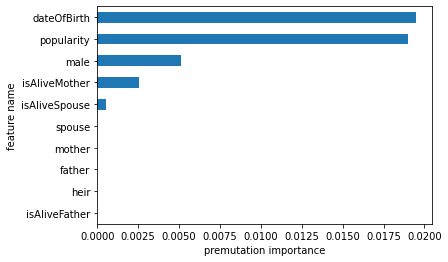

In [12]:
#Visualize what the top importances are
#Create plot
pd.Series(permutated['importances_mean'], index=cols_drop).sort_values().tail(10).plot(kind='barh')

#set x label
plt.xlabel('premutation importance')

#set y label
plt.ylabel('feature name')

In [13]:
#Use xgboost to create new model
xgb_model = make_pipeline(OrdinalEncoder(),
                         XGBClassifier(n_estimators=100,
                                      max_depth=20,
                                      learning_rate=1e-3,
                                      n_jobs=-2))

#Fit model
xgb_model.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:15:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['title', 'culture', 'mother', 'father',
                                      'heir', 'spouse'],
                                mapping=[{'col': 'title',
                                          'data_type': dtype('O'),
                                          'mapping': NaN                      1
Septon                   2
Ser                      3
Dreadfort                4
Iron Islands             5
                      ... 
Tower of Glimmering    227
Broad Arch             228
Three Towers           229
Cobblecat              230
Big BucketThe Wull     231
Length: 231, dtype: int64},
                                         {'col': 'culture',
                                          'data_type': dtype('O'),
                                          'map...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                        

In [14]:
#Check metric of new model
#training accuracy
print('XGBoost Training set accuracy',xgb_model.score(X_train, y_train))

#validation accuracy
print('XGBoost Validation set accuracy',xgb_model.score(X_val, y_val))

XGBoost Training set accuracy 0.8695372750642674
XGBoost Validation set accuracy 0.782051282051282


In [15]:
#Perdform grid search
param_grid = {
    #set imputer strategy
    'simpleimputer__strategy': ['mean', 'median'],
    #set depth range for random forrest
    'randomforestclassifier__max_depth': range(5,40,5),
    #set range of number of trees in forest
    'randomforestclassifier__n_estimators': range(25, 125, 25)
}

#Build grid model
grid_model = GridSearchCV(
    model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1
)

#trian model
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['title', 'culture',
                                                             'mother', 'father',
                                                             'heir', 'spouse'],
                                                       mapping=[{'col': 'title',
                                                                 'data_type': dtype('O'),
                                                                 'mapping': NaN                      1
Septon                   2
Ser                      3
Dreadfort                4
Iron Islands             5
                      ... 
Tower of Glimmering    227
Broad Arch             228
Three Towers           229
Cobblecat              230
Big BucketThe Wull     231
Length: 231, dtype: int64},
                                                                {'col': 'culture'...
Joanna Lannister     203

In [16]:
#Check metrics
#Best model parameters
print('Best params for model:', grid_model.best_params_)

#best possible score 
print('Best score possible:', grid_model.best_score_)

Best params for model: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 75, 'simpleimputer__strategy': 'mean'}
Best score possible: 0.802712507214115
